# Regressorion with Orbit - Advance

In this demo, we want to demonstartate further how to config orbit to perform regressions with time-series analysis.  The config including different regularizations and we use a simulated data set to compare against ground truth. 

In [1]:
import pandas as pd
import numpy as np

# from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from orbit.dlt import DLT
from orbit.lgt import LGT

from orbit.utils.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative_regression

In [2]:
# randomization is using numpy with this version
print(np.__version__)

1.18.2


## Simulation of Regression with Trend

In [3]:
# To scale regressor values in a nicer way
REG_BASE = 1000
NUM_OF_REGRESSORS = 10
SEED = 2020

In [4]:
raw_df, coefs, trend, seas = make_ts_multiplicative_regression(
    series_len=200, seasonality=52, num_of_regressors=NUM_OF_REGRESSORS, 
    coef_mean=.03, coef_sd=.1,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_prob=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)

In [5]:
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,regressor_10,date
0,1982.0,0.0,1842.0,2548.0,1047.0,0.0,1755.0,1858.0,1871.0,912.0,0.0,2016-01-10
1,2178.0,1429.0,2055.0,1936.0,1974.0,1765.0,0.0,1272.0,1469.0,0.0,3932.0,2016-01-17
2,2103.0,2447.0,0.0,819.0,1753.0,2383.0,0.0,0.0,1685.0,1146.0,0.0,2016-01-24
3,846.0,1315.0,1771.0,0.0,0.0,0.0,0.0,0.0,0.0,1612.0,0.0,2016-01-31
4,1663.0,0.0,1352.0,2183.0,1198.0,1432.0,1030.0,1262.0,1887.0,0.0,2649.0,2016-02-07


In [6]:
print(coefs)

[ 0.15602066  0.05231785  0.16325487 -0.11182046  0.0027203   0.0366778
  0.05510171  0.05726848 -0.14605049  0.13879701]


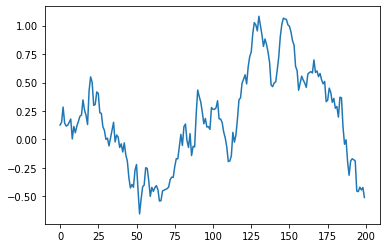

In [7]:
plt.plot(trend)

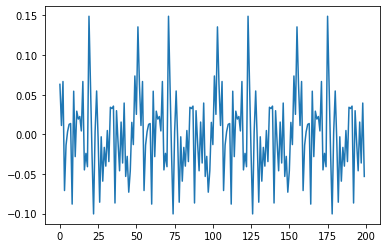

In [8]:
plt.plot(seas)

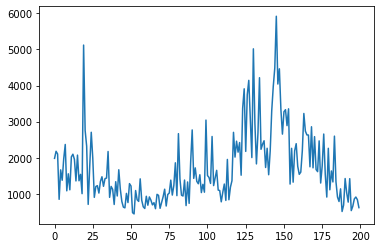

In [9]:
plt.plot(raw_df['response'])

## Estimating Coefficients I - full relevance

Assume we observe the data frame `df` and the scaler `REG_BASE`

In [10]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [11]:
mod_lasso = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
mod_auto_ridge = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [13]:
mod_fixed_ridge1 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
mod_fixed_ridge2 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

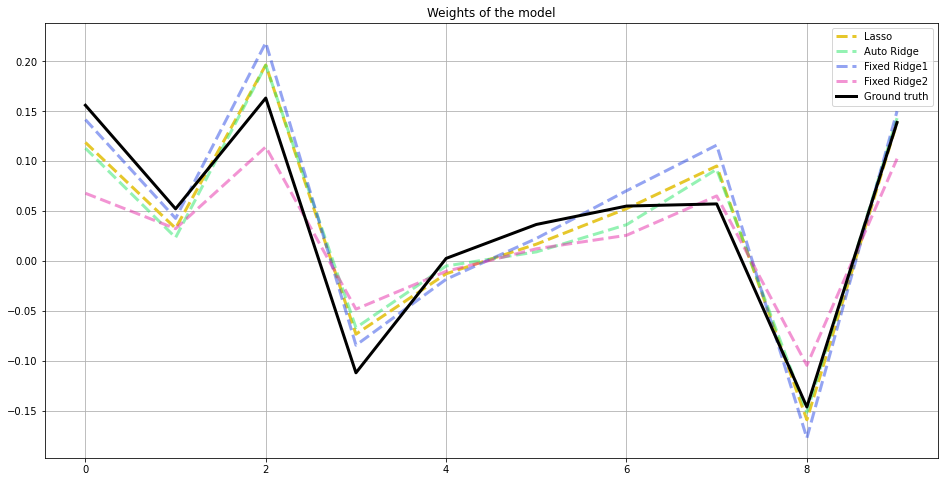

In [16]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

## Checking Model Convergence and Posterior Distribution

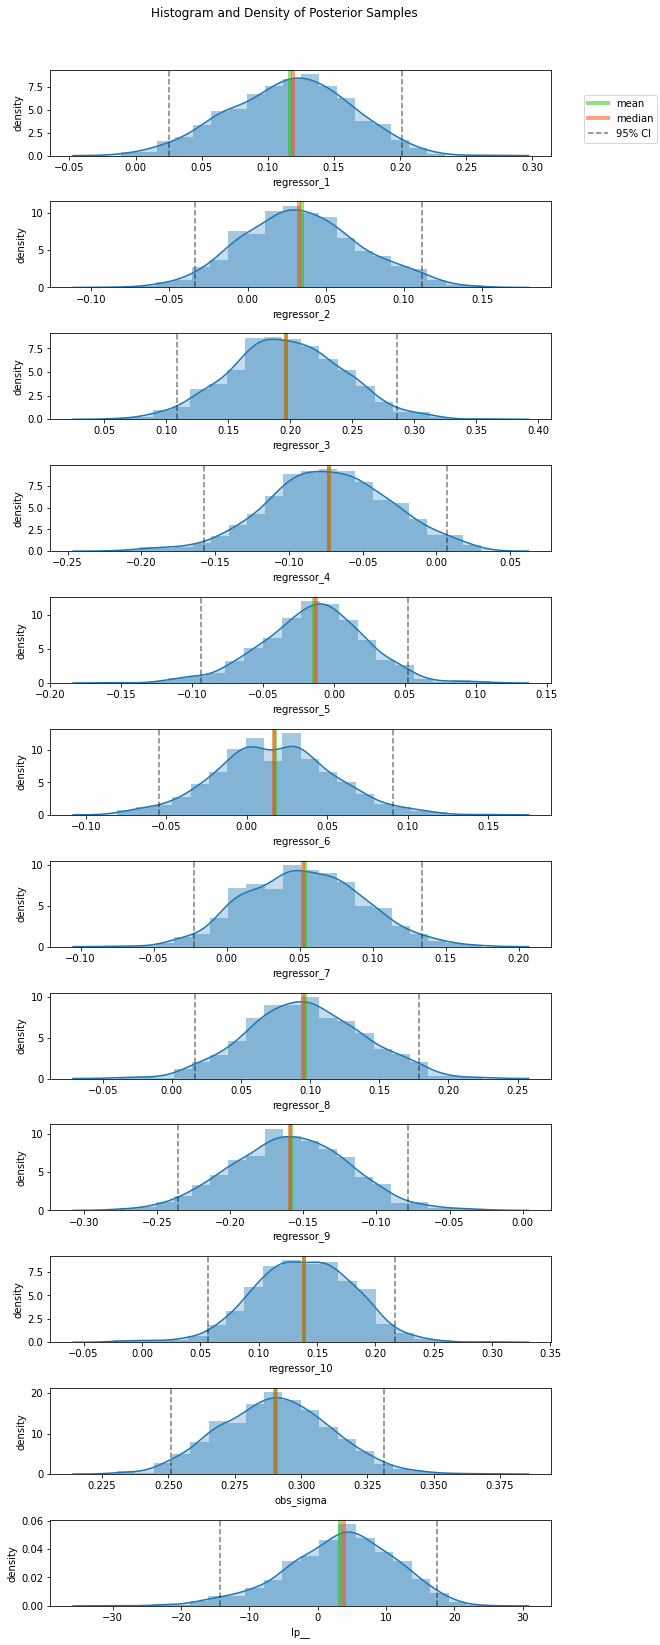

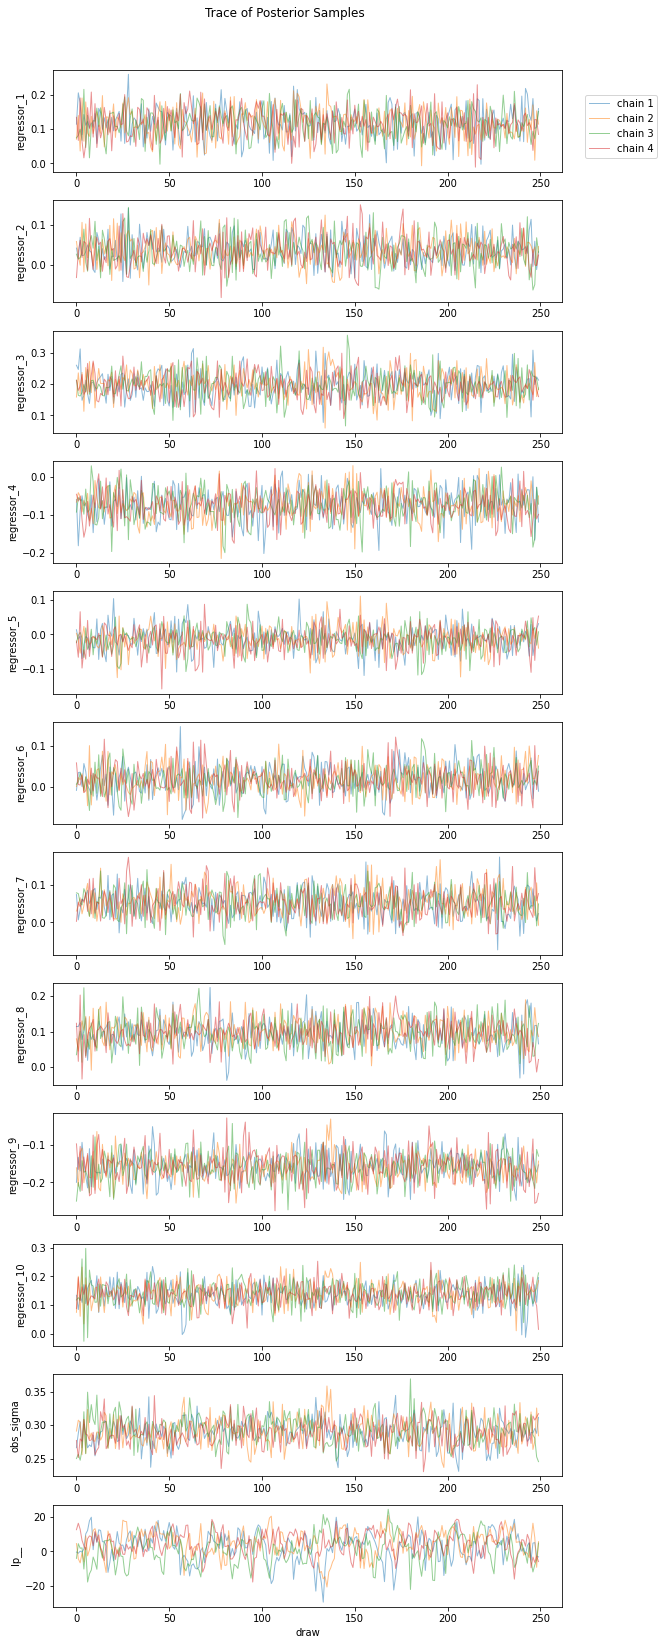

In [17]:
_ = mod_lasso.predict(df)
_ = plot_posterior_params(mod_lasso, kind='density')
_ = plot_posterior_params(mod_lasso, kind='trace')

## Estimating Coefficients II - high sparsity

In [18]:
NUM_OF_REGRESSORS = 25
REGRESSOR_SPARSITY = 0.8

In [19]:
raw_df, coefs, trend, seas = make_ts_multiplicative_regression(
    series_len=200, seasonality=52, num_of_regressors=NUM_OF_REGRESSORS, regressor_sparsity=REGRESSOR_SPARSITY,
    coef_mean=.03, coef_sd=.1,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_prob=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,...,regressor_17,regressor_18,regressor_19,regressor_20,regressor_21,regressor_22,regressor_23,regressor_24,regressor_25,date
0,4573.0,0.0,1842.0,2548.0,1047.0,0.0,1755.0,1858.0,1871.0,912.0,...,1272.0,1469.0,0.0,3932.0,2447.0,0.0,819.0,1753.0,2383.0,2016-01-10
1,1946.0,0.0,0.0,1685.0,1146.0,0.0,1315.0,1771.0,0.0,0.0,...,1352.0,2183.0,1198.0,1432.0,1030.0,1262.0,1887.0,0.0,2649.0,2016-01-17
2,3485.0,0.0,0.0,791.0,0.0,0.0,1805.0,0.0,1685.0,1179.0,...,0.0,2223.0,1749.0,1745.0,1751.0,0.0,2092.0,0.0,1701.0,2016-01-24
3,1238.0,2278.0,0.0,1707.0,0.0,2369.0,1234.0,0.0,1842.0,0.0,...,1419.0,0.0,1273.0,0.0,0.0,1334.0,0.0,1579.0,2985.0,2016-01-31
4,1226.0,1630.0,0.0,0.0,0.0,973.0,0.0,0.0,1295.0,1452.0,...,2595.0,2804.0,0.0,0.0,1906.0,1930.0,1312.0,0.0,2237.0,2016-02-07


In [20]:
print(coefs)

[ 0.          0.05231785  0.16325487 -0.11182046  0.          0.
  0.05510171  0.          0.          0.          0.          0.
  0.06847838  0.          0.03854218  0.         -0.0597671   0.
  0.          0.32790427  0.14872741 -0.02134489 -0.17082483  0.
  0.13933526]


In [21]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [22]:
mod_lasso = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [23]:
mod_auto_ridge = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [24]:
mod_fixed_ridge1 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [25]:
mod_fixed_ridge2 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [26]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

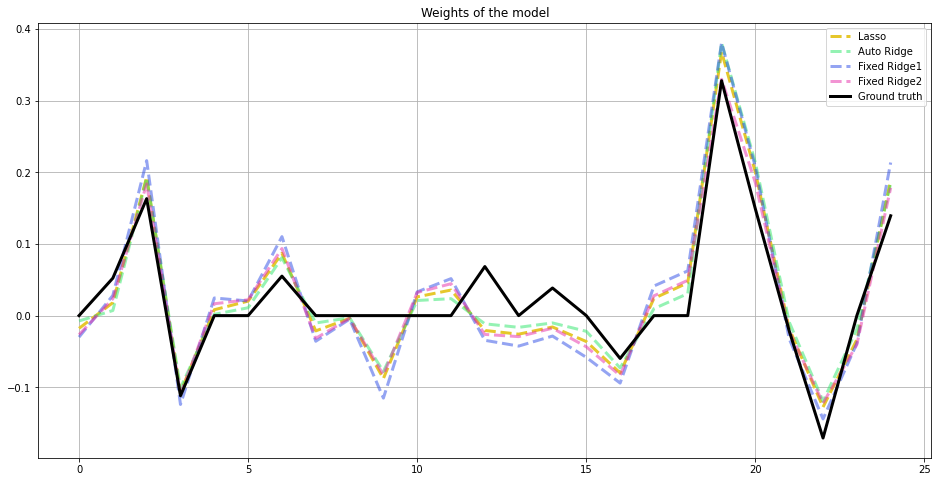

In [27]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()